In [ ]:
!pip install torch_optimizer

In [ ]:
import numpy as np
import random
import math
import time
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

from torch.optim import Optimizer
import torch_optimizer as optim

from torchvision import datasets
from torchvision.transforms import transforms

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
name = torch.cuda.get_device_name(0)
print("GPU: " + name)

random_seed = 0

torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

np.random.seed(random_seed)
random.seed(random_seed)

cuda:0
GPU: Tesla T4


In [ ]:
class EarlyStopping:
    def __init__(self, patience=10):
        
        self.patience = patience
        self.counter = 0
        self.best_score = None
        self.val_loss_min = np.Inf
        self.early_stop = False

        self.path = 'checkpoint.pt'



    def __call__(self, val_loss, model):

        score = val_loss

        if self.best_score is None:
            self.best_score = score
            
            print('Validation loss decreased ({:.4f} --> {:.4f}).  Saving model ...'.format(self.val_loss_min, val_loss))
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss

        elif score > self.best_score:
            self.counter += 1
            print("EarlyStopping counter: {} out of {}".format(self.counter, self.patience))

            if self.counter >= self.patience:
                self.early_stop = True

        else:
            self.best_score = score
            self.counter = 0

            print('Validation loss decreased --- Saving model ...')
            torch.save(model.state_dict(), self.path)
            self.val_loss_min = val_loss

In [ ]:
def create_datasets(batch_size):

    valid_size = 0.2

    transform = transforms.Compose([
                                    transforms.Pad(4),
                                    transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(32),
                                    transforms.ToTensor()
    ])

    train_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                     train=True,
                                     transform=transform,
                                     download=True)
    
    test_dataset = datasets.CIFAR10(root='./cifar_10data/',
                                    train=False,
                                    transform=transforms.ToTensor(),
                                    download=True)
    
    len_train = len(train_dataset)
    index_train = list(range(len_train))
    np.random.shuffle(index_train)

    split = int(valid_size * len_train)
    train_index, valid_index = index_train[split:], index_train[:split]

    train_sampler = SubsetRandomSampler(train_index)
    valid_sampler = SubsetRandomSampler(valid_index)

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = train_sampler,
                                               num_workers=0)
    
    valid_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=batch_size,
                                               sampler = valid_sampler,
                                               num_workers=0)
    
    test_loader = torch.utils.data.DataLoader(test_dataset,
                                              batch_size=batch_size,
                                              num_workers=0)    
    
    return train_loader, valid_loader, test_loader

In [ ]:
def train_model(model, batch_size, n_epochs, patience):
    
    train_losses = []
    valid_losses = []

    avg_train_losses = []
    avg_valid_losses = []

    early_stopping = EarlyStopping(patience=patience)

    model.train()

    start = time.time()

    for epoch in range(1,n_epochs+1):
        print("{}th Epoch starting.".format(epoch))

        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()

            output = model(images)

            train_loss = loss_function(output, labels)

            train_loss.backward()

            optimizer.step()

            loss = train_loss.item()


            train_losses.append(loss)


        model.eval()

        with torch.no_grad():
            for images, labels in valid_loader:
                images , labels = images.to(device), labels.to(device)

                output = model(images)

                valid_loss = loss_function(output, labels)

                loss = valid_loss.item()

                valid_losses.append(loss)
        
        loss_train = np.average(train_losses)
        loss_valid = np.average(valid_losses)

        avg_train_losses.append(loss_train)
        avg_valid_losses.append(loss_valid)

        print("Epoch [{}] Train Loss: {:.4f} & Validation Loss: {:.4f}".format(epoch, loss_train, loss_valid))

        train_losses = []
        valid_losses = []

        early_stopping(loss_valid, model)

        if early_stopping.early_stop:
            print("Early Stopping!!")
            end = time.time()
            print(end-start)
            break

    model.load_state_dict(torch.load('checkpoint.pt'))

    return model, avg_train_losses, avg_valid_losses

In [ ]:
def test_model(model):
    model.eval()
    test_loss, correct, total = 0, 0, 0

    with torch.no_grad():
        for images, labels in test_loader :
            images, labels = images.to(device), labels.to(device)

            output = model(images)
            test_loss += loss_function(output, labels).item()

            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(labels.view_as(pred)).sum().item()

            total += labels.size(0)

    print('[Test set] Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
            test_loss /total, correct, total,
            100. * correct / total))

In [ ]:
def plot_loss(train_loss, valid_loss, y_scale = 5, title = ""):

    fig = plt.figure(figsize=(10,8))
    plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
    plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')


    minposs = valid_loss.index(min(valid_loss))+1 
    plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.ylim(0, y_scale) 
    plt.xlim(0, len(train_loss)+1)
    plt.title(title) 
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    fig.savefig('loss_plot.png', bbox_inches='tight')

In [ ]:
class GoogLeNet(nn.Module):

    def __init__(self):
        super(GoogLeNet, self).__init__()        

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, padding=3)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=5)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)  # 64 + 128 + 32 + 32 = 256
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)


        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, 10)
        
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                torch.nn.init.kaiming_uniform_(m.weight)

    def forward(self, x):
        # N x 3 x 32 x 32
        x = self.conv1(x)
        # N x 64 x 32 x 32
        x = self.conv2(x)
        # N x 64 x 32 x 32
        x = self.conv3(x)
        # N x 192 x 28 x 28

        # N x 192 x 28 x 28
        x = self.inception3a(x)
        # N x 256 x 28 x 28
        x = self.inception3b(x)
        # N x 480 x 28 x 28
        x = self.maxpool3(x)
        # N x 480 x 14 x 14
        x = self.inception4a(x)
        # N x 512 x 14 x 14
        x = self.inception4b(x)
        # N x 512 x 14 x 14
        x = self.inception4c(x)
        # N x 512 x 14 x 14
        x = self.inception4d(x)
        # N x 528 x 14 x 14
        x = self.inception4e(x)
        # N x 832 x 14 x 14
        x = self.maxpool4(x)
        # N x 832 x 7 x 7
        x = self.inception5a(x)
        # N x 832 x 7 x 7
        x = self.inception5b(x)
        # N x 1024 x 7 x 7
        x = self.avgpool(x)
        # N x 1024 x 1 x 1
        x = torch.flatten(x, 1)
        # N x 1024
        x = self.dropout(x)
        x = self.fc(x)
        # N x 10 (num_classes)
        return x

In [ ]:
class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj):
        super(Inception, self).__init__()
        
        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=5, padding=2)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1),
            BasicConv2d(in_channels, pool_proj, kernel_size=1)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        return torch.cat([branch1, branch2, branch3, branch4], 1)


class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Sequential(
                            nn.Conv2d(in_channels, out_channels, **kwargs),
                            nn.BatchNorm2d(out_channels),   #Batch norm here
                            nn.ReLU()
                            )
    def forward(self, x):
        return self.conv(x)

In [ ]:
model = GoogLeNet().to(device)

loss_function = nn.CrossEntropyLoss()

optimizer = optim.RAdam(model.parameters(), weight_decay=5e-4)

In [ ]:
batch_size = 256
n_epochs = 250

train_loader, test_loader, valid_loader = create_datasets(batch_size)

patience = 25

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
model, train_loss, valid_loss = train_model(model, batch_size, n_epochs, patience)

1th Epoch starting.
Epoch [1] Train Loss: 1.8034 & Validation Loss: 1.4568
Validation loss decreased (inf --> 1.4568).  Saving model ...
2th Epoch starting.
Epoch [2] Train Loss: 2.0728 & Validation Loss: 1.7888
EarlyStopping counter: 1 out of 25
3th Epoch starting.
Epoch [3] Train Loss: 1.5912 & Validation Loss: 1.4443
Validation loss decreased --- Saving model ...
4th Epoch starting.
Epoch [4] Train Loss: 1.4323 & Validation Loss: 1.2927
Validation loss decreased --- Saving model ...
5th Epoch starting.
Epoch [5] Train Loss: 1.3309 & Validation Loss: 1.2975
EarlyStopping counter: 1 out of 25
6th Epoch starting.
Epoch [6] Train Loss: 1.2101 & Validation Loss: 1.1075
Validation loss decreased --- Saving model ...
7th Epoch starting.
Epoch [7] Train Loss: 1.1274 & Validation Loss: 1.1182
EarlyStopping counter: 1 out of 25
8th Epoch starting.
Epoch [8] Train Loss: 1.0376 & Validation Loss: 1.2779
EarlyStopping counter: 2 out of 25
9th Epoch starting.
Epoch [9] Train Loss: 0.9668 & Valida

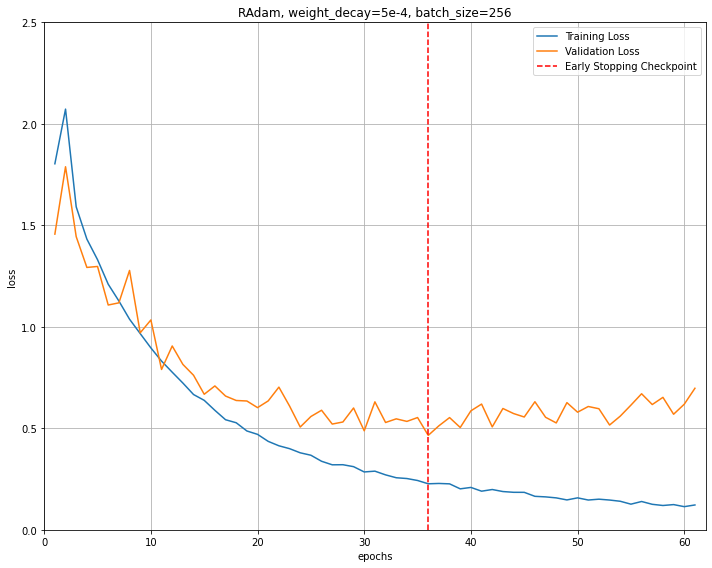

In [ ]:
plot_loss(train_loss, valid_loss,2.5,title='RAdam, weight_decay=5e-4, batch_size=256')

In [ ]:
test_model(model)

[Test set] Average loss: 0.0018, Accuracy: 8543/10000 (85.43%)

